In [1]:
import os
import sys
from functools import partial
from pathlib import Path

path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
from fastai2.vision.all import Learner

from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.callback.core_cbs import CheckpointCallback, ConfigCallback
from src.metrics.mAP import mAP
from src.config.retinanet import config

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_PATH = Path('/userhome/34/h3509807/wheat-data')
MODEL_DIR = Path('lr_find')
RESIZE_SZ = 256
RAND_SEED = 144
TEST_MODE = False
BS = 32
ARCH = 'resnet50-coco'
BIAS = -2
GAMMA = 1.
ALPHA = 0.5
RATIOS = [0.5, 1, 2.0]
SCALES = [1.0, 0.6, 0.3]

In [4]:
get_dls = partial(build_dataloaders, data_path = DATA_PATH,
                  resize_sz = RESIZE_SZ, norm = True,
                  rand_seed = RAND_SEED, test_mode = TEST_MODE)
dls = get_dls(bs = BS)

model = get_retinanet(ARCH, BIAS)
retinanet_loss = get_retinanet_loss(gamma = GAMMA, alpha = ALPHA,
                                    ratios = RATIOS, scales = SCALES)

learn = Learner(dls, model, path = Path('./models'), 
                model_dir = MODEL_DIR,
                loss_func = retinanet_loss, 
                train_bn = True,
                splitter = split_param_groups)
learn.freeze()
learn.summary()

resnet50-coco is selected


RetinaNet (Input shape: ['32 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 128 x 128  9,408      False     
________________________________________________________________
FrozenBatchNorm2d    32 x 64 x 128 x 128  0          False     
________________________________________________________________
ReLU                 32 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               32 x 64 x 64 x 64    4,096      False     
________________________________________________________________
FrozenBatchNorm2d    32 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               32 x 64 x 64 x 64    36,864     False     
__________________________________________________

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=3.0199516913853586e-05)

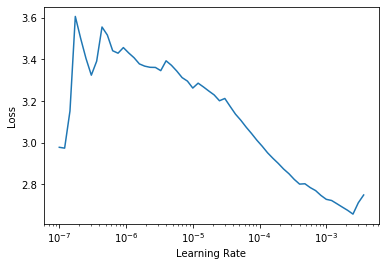

In [5]:
learn.lr_find()